In this notebook, I will implement a few recommendation algorithm (Popularity based, content based and collaborative filtering) and build an ensemble of these models to come up with final recommendation system.

- Data Sources: Data is collected from TMDB and Group Lens.

We have 2 movie lens datasets - 
1. Full Dataset: Consists of 26000000 ratings and 750000 tag applications applied to 45,000 movies by 270,000 users. Includes tag genome data with 12M relevance scores across 1,100 tags.
2. Small Dataset: Comprises of 100,000 ratings and 1300 tag applications applied to 9000 movies by 700 users.

I will build using small dataset due to computation power limitation on my local desktop.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from ast import literal_eval

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

from surprise import Reader, Dataset, SVD

import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
%matplotlib inline

In [2]:
movies_metadata_df = pd.read_csv('./Source Data/movies_metadata/movies_metadata.csv', encoding = 'iso-8859-1')
movies_metadata_df.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0


In [11]:
movies_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

# Popularity Based Recommendation System

The idea behinf this recommendation is - the movies that are most popular and more critically acclaimed have higer probability of being liked by the average audience.

Points to note:
- No personalised recommendations

Implementation:
- We will use ratings and popularity
- Can also provide genre based recommendation

In [145]:
#Filter out only required fields

metadata_df_on_popularity = movies_metadata_df[['title','release_date','vote_count','vote_average','popularity','genres']]

In [24]:
#Sanity Check

metadata_df_on_popularity.shape

(45466, 6)

In [25]:
metadata_df_on_popularity.dtypes

title            object
release_date     object
vote_count      float64
vote_average    float64
popularity       object
genres           object
dtype: object

In [ ]:
#Columns are imported with wrong datatype. May be because of missing data in those columns. Let's check further.

In [146]:
#Check missing data
pd.concat([metadata_df_on_popularity.isnull().sum(), 100 * metadata_df_on_popularity.isnull().sum()/metadata_df_on_popularity.shape[0]], axis = 1, keys = ['Total','Percent'])

,Total,Percent
title,6,0.013197
release_date,87,0.191352
vote_count,6,0.013197
vote_average,6,0.013197
popularity,5,0.010997
genres,0,0.000000


- title can be computed from original title field
- 1 movie can belong to different genre. I see that genres field is json but with object datatype. Let's convert it to json field and also make a genre string field with only name values.
    -- Example Genre value right now:
    [{'id': 16, 'name': 'Animation'},
 {'id': 35, 'name': 'Comedy'},
 {'id': 10751, 'name': 'Family'}]

In [147]:
metadata_df_on_popularity['genres'] = metadata_df_on_popularity['genres'].fillna('[Unknown]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if ((isinstance(x,list)) and (x)) else ['Unknown'])


In [148]:
# Handle missing data - vote_counts
metadata_df_on_popularity[metadata_df_on_popularity['vote_count'].isnull()]

,title,release_date,vote_count,vote_average,popularity,genres
19729,NaN,NaN,NaN,NaN,NaN,"[Action, Thriller, Drama]"
19730,NaN,1,NaN,NaN,NaN,"[Carousel Productions, Vision View Entertainme..."
29502,NaN,NaN,NaN,NaN,NaN,"[Animation, Science Fiction]"
29503,NaN,12,NaN,NaN,NaN,"[Aniplex, GoHands, BROSTA TV, Mardock Scramble..."
35586,NaN,NaN,NaN,NaN,NaN,"[TV Movie, Action, Horror, Science Fiction]"
35587,NaN,22,NaN,NaN,Beware Of Frost Bites,"[Odyssey Media, Pulser Productions, Rogue Stat..."


I see that above list of movies does't add any value in our recommendation system. So, let's drop them.

In [149]:
metadata_df_on_popularity.shape

(45466, 6)

In [150]:
metadata_df_on_popularity = metadata_df_on_popularity[metadata_df_on_popularity['vote_count'].notna()]
metadata_df_on_popularity.shape

(45460, 6)

In [151]:
#Check missing data
pd.concat([metadata_df_on_popularity.isnull().sum(), 100 * metadata_df_on_popularity.isnull().sum()/metadata_df_on_popularity.shape[0]], axis = 1, keys = ['Total','Percent'])

,Total,Percent
title,0,0.000000
release_date,84,0.184778
vote_count,0,0.000000
vote_average,0,0.000000
popularity,0,0.000000
genres,0,0.000000


In [152]:
# Handle missing data - release_date
metadata_df_on_popularity[metadata_df_on_popularity['release_date'].isnull()]

,title,release_date,vote_count,vote_average,popularity,genres
711,War Stories Our Mother Never Told Us,NaN,0.0,0.0,0.005625,[Unknown]
734,Vermont Is for Lovers,NaN,0.0,0.0,0.75,[Unknown]
3460,"Jails, Hospitals & Hip-Hop",NaN,0.0,0.0,0.009057,[Drama]
3628,Boricua's Bond,NaN,1.0,2.0,0.035352,[Unknown]
5879,Divine Intervention,NaN,0.0,0.0,0.001181,"[Drama, Romance, Foreign]"
13839,Bling: A Planet Rock,NaN,0.0,0.0,0,[Unknown]
14801,Dead Ahead: The Exxon Valdez Disaster,NaN,1.0,5.0,0.035294,[Unknown]
16836,Das Experiment 770 - GebÃ¤ren auf Befehl,NaN,0.0,0.0,0,[Unknown]
16953,Connections,NaN,1.0,9.0,0.035294,[Unknown]
17339,Human Failure,NaN,0.0,0.0,0.294095,[Documentary]


In [153]:
metadata_df_on_popularity = metadata_df_on_popularity[metadata_df_on_popularity['release_date'].notna()]
metadata_df_on_popularity.shape

(45376, 6)

In [154]:
not metadata_df_on_popularity.loc[45465:]['genres'].values[0]

False

In [155]:
not metadata_df_on_popularity.loc[1:1,:]['genres'].values[0]

False

In [156]:
metadata_df_on_popularity.head()

,title,release_date,vote_count,vote_average,popularity,genres
0,Toy Story,1995-10-30,5415.0,7.7,21.9469,"[Animation, Comedy, Family]"
1,Jumanji,1995-12-15,2413.0,6.9,17.0155,"[Adventure, Fantasy, Family]"
2,Grumpier Old Men,1995-12-22,92.0,6.5,11.7129,"[Romance, Comedy]"
3,Waiting to Exhale,1995-12-22,34.0,6.1,3.85949,"[Comedy, Drama, Romance]"
4,Father of the Bride Part II,1995-02-10,173.0,5.7,8.38752,[Comedy]


Rather than going ahead only with popularity and vote_average, IMDB decides the rating based on weighted average. Means not all the votes have the same weight or impact in the final rating.
Source: https://help.imdb.com/article/imdb/track-movies-tv/weighted-average-ratings/GWT2DSBYVT2F25SK#

We will use below formula to calculate weighted average rating of all movies. 
Source: https://math.stackexchange.com/questions/169032/understanding-the-imdb-weighted-rating-function-for-usage-on-my-own-website

Weighted Rating(WR) = (v/(v+m))R + (m/(v+m))C

where:
1. v = vote_count: number of votes for the movie
2. m = minimum votes required to be listed in top movies list
3. R = average for the movie = vote_average
4. C = mean vote across the whole report


-- Next steps is to calculate the value of m. As a trial - I will use 95th percententile as a cutoff mark for the number of votes means the movie should have more votes than atleast 95% of the movies in the list.

In [157]:
metadata_df_on_popularity.dtypes

title            object
release_date     object
vote_count      float64
vote_average    float64
popularity       object
genres           object
dtype: object

In [160]:
C = metadata_df_on_popularity['vote_average'].mean()
m = metadata_df_on_popularity['vote_count'].quantile(0.95)
#v = vote_count
#R = vote_average
C,m

(5.624069992947519, 434.0)

In [162]:
#Let's drop unqualified movies
print(metadata_df_on_popularity.shape)
metadata_df_on_popularity = metadata_df_on_popularity[metadata_df_on_popularity['vote_count']>=m]
print('Qualified movies:', metadata_df_on_popularity.shape[0])

(45376, 6)
Qualified movies: 2274


#Only 2274 movis are in qualified list of popularity.

In [163]:
#Calclate average rating
def calc_weightedAverage(x):
    v = x['vote_count']
    R = x['vote_average']
    return ((v/(v+m)) * R) + ((m/(v+m)) * C)


In [165]:
metadata_df_on_popularity['wr'] = metadata_df_on_popularity.apply(lambda x: calc_weightedAverage(x), axis =1)
metadata_df_on_popularity.head()

,title,release_date,vote_count,vote_average,popularity,genres,wr
0,Toy Story,1995-10-30,5415.0,7.7,21.9469,"[Animation, Comedy, Family]",7.545965
1,Jumanji,1995-12-15,2413.0,6.9,17.0155,"[Adventure, Fantasy, Family]",6.705496
5,Heat,1995-12-15,1886.0,7.7,17.9249,"[Action, Crime, Drama, Thriller]",7.311658
9,GoldenEye,1995-11-16,1194.0,6.6,14.686,"[Adventure, Action, Thriller]",6.339832
15,Casino,1995-11-22,1343.0,7.8,10.1374,"[Drama, Crime]",7.268569


#### Top 50 movies on the basis of popularity (wr)

In [166]:
metadata_df_on_popularity.sort_values('wr', ascending=False).head(50)

,title,release_date,vote_count,vote_average,popularity,genres,wr
314,The Shawshank Redemption,1994-09-23,8358.0,8.5,51.6454,"[Drama, Crime]",8.358035
834,The Godfather,1972-03-14,6024.0,8.5,41.1093,"[Drama, Crime]",8.306728
12481,The Dark Knight,2008-07-16,12269.0,8.3,123.167,"[Drama, Action, Crime, Thriller]",8.208576
2843,Fight Club,1999-10-15,9678.0,8.3,63.8696,[Drama],8.185151
292,Pulp Fiction,1994-09-10,8670.0,8.3,140.95,"[Thriller, Crime]",8.172435
351,Forrest Gump,1994-07-06,8147.0,8.2,48.3072,"[Comedy, Drama, Romance]",8.069718
522,Schindler's List,1993-11-29,4436.0,8.3,41.7251,"[Drama, History, War]",8.061529
23673,Whiplash,2014-10-10,4376.0,8.3,64.3,[Drama],8.058554
5481,Spirited Away,2001-07-20,3968.0,8.3,41.0489,"[Fantasy, Adventure, Animation, Family]",8.036176
1154,The Empire Strikes Back,1980-05-17,5998.0,8.2,19.471,"[Adventure, Action, Science Fiction]",8.026189


Let's now see top movies in each genre

In [170]:
s = metadata_df_on_popularity.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
metadata_df_on_popularity_genre = metadata_df_on_popularity.drop('genres', axis = 1).join(s)
metadata_df_on_popularity_genre.shape

(6261, 7)

In [171]:
metadata_df_on_popularity_genre.head()

,title,release_date,vote_count,vote_average,popularity,wr,genre
0,Toy Story,1995-10-30,5415.0,7.7,21.9469,7.545965,Animation
0,Toy Story,1995-10-30,5415.0,7.7,21.9469,7.545965,Comedy
0,Toy Story,1995-10-30,5415.0,7.7,21.9469,7.545965,Family
1,Jumanji,1995-12-15,2413.0,6.9,17.0155,6.705496,Adventure
1,Jumanji,1995-12-15,2413.0,6.9,17.0155,6.705496,Fantasy


In [180]:
def top_ten_in_genre(genre):
    return metadata_df_on_popularity_genre[metadata_df_on_popularity_genre['genre']==genre].sort_values('wr', ascending=False).head(10)

In [181]:
top_ten_in_genre('Animation')

,title,release_date,vote_count,vote_average,popularity,wr,genre
5481,Spirited Away,2001-07-20,3968.0,8.3,41.0489,8.036176,Animation
359,The Lion King,1994-06-23,5520.0,8.0,21.6058,7.826813,Animation
30315,Inside Out,2015-06-09,6737.0,7.9,23.9856,7.762257,Animation
9698,Howl's Moving Castle,2004-11-19,2049.0,8.2,16.136,7.749757,Animation
2884,Princess Mononoke,1997-07-12,2041.0,8.2,17.1667,7.748302,Animation
13724,Up,2009-05-13,7048.0,7.8,19.3309,7.673783,Animation
12704,WALLÂ·E,2008-06-22,6439.0,7.8,16.0884,7.662600,Animation
24455,Big Hero 6,2014-10-24,6289.0,7.8,213.85,7.659534,Animation
40251,Your Name.,2016-08-26,1030.0,8.5,34.461252,7.647436,Animation
0,Toy Story,1995-10-30,5415.0,7.7,21.9469,7.545965,Animation


In [183]:
top_ten_in_genre('Romance')

,title,release_date,vote_count,vote_average,popularity,wr,genre
351,Forrest Gump,1994-07-06,8147.0,8.2,48.3072,8.069718,Romance
10309,Dilwale Dulhania Le Jayenge,1995-10-20,661.0,9.1,34.457,7.722325,Romance
40882,La La Land,2016-11-29,4745.0,7.9,19.681686,7.709277,Romance
22168,Her,2013-12-18,4215.0,7.9,13.8295,7.687534,Romance
7208,Eternal Sunshine of the Spotless Mind,2004-03-19,3758.0,7.9,12.9063,7.664372,Romance
40251,Your Name.,2016-08-26,1030.0,8.5,34.461252,7.647436,Romance
4843,AmÃ©lie,2001-04-25,3403.0,7.8,12.8794,7.553882,Romance
24982,The Theory of Everything,2014-11-26,3403.0,7.8,11.853,7.553882,Romance
7834,The Notebook,2004-06-25,3163.0,7.7,15.239,7.449526,Romance
4865,A Beautiful Mind,2001-12-11,3087.0,7.7,11.9365,7.444120,Romance


### Note - We can reduce qualified movie limit to 85th percentile votes as a min threshold to get movie list for each genre to get more latest movies.

Drawbacks of previous approach:
- No personalised recommendation. 
    - what if a person loves comedy but hates romance?
    - Content preferences of user about favourite actor/dirctor

# Content Based Recommender

I will build 2 recommenders with crietria as:
- Movie overview and taglines
- movie cast, crew, keywords and genre

In [3]:
links_small_df = pd.read_csv('./Source Data/links_small.csv', encoding = 'iso-8859-1')
links_small_df.shape

(9125, 3)

In [186]:
links_small_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [4]:
#initial dataset

movies_metadata_df['genres'] = movies_metadata_df['genres'].fillna('[Unknown]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if ((isinstance(x,list)) and (x)) else ['Unknown'])

# Handle missing data - vote_count
movies_metadata_df = movies_metadata_df[movies_metadata_df['vote_count'].notna()]

# Handle missing data - release_date
movies_metadata_df = movies_metadata_df[movies_metadata_df['release_date'].notna()]
movies_metadata_df.shape

(45376, 24)

In [191]:
pd.concat([movies_metadata_df.isnull().sum(), 100 * movies_metadata_df.isnull().sum()/movies_metadata_df.shape[0]], axis = 1, keys = ['Total','Percent'])

,Total,Percent
adult,0,0.000000
belongs_to_collection,40888,90.109309
budget,0,0.000000
genres,0,0.000000
homepage,37610,82.885226
id,0,0.000000
imdb_id,14,0.030853
original_language,11,0.024242
original_title,0,0.000000
overview,941,2.073783


In [225]:
links_small_df.isnull().sum()

movieId     0
imdbId      0
tmdbId     13
dtype: int64

In [6]:
print(links_small_df.shape)
links_small_df = links_small_df.dropna()
print(links_small_df.shape)

(9125, 3)
(9112, 3)


In [7]:
#Change id datatype to int

movies_metadata_df['id'] = movies_metadata_df['id'].astype('int')
links_small_df['tmdbId'] = links_small_df['tmdbId'].astype('int')
print(movies_metadata_df.shape)
movies_metadata_resized_df = movies_metadata_df[movies_metadata_df['id'].isin(links_small_df['tmdbId'])]
print(movies_metadata_resized_df.shape)

(45376, 24)
(9099, 24)


In [ ]:
#Reduced the size to 9099 movies

#### Movie description + tagline based recommender

In [230]:
#Fill missing data with blanks

movies_metadata_resized_df['tagline'] = movies_metadata_resized_df['tagline'].fillna('')
movies_metadata_resized_df['overview'] = movies_metadata_resized_df['overview'].fillna('')


In [231]:
#Create new field description as a concat result of overview and tagline

movies_metadata_resized_df['description'] = movies_metadata_resized_df['tagline'] + movies_metadata_resized_df['overview']

In [232]:
#Create TF-IDF vector for texts
tfidf = TfidfVectorizer(analyzer = 'word', ngram_range=(1,2), stop_words = 'english', min_df = 0)
tfidf_matrix = tfidf.fit_transform(movies_metadata_resized_df['description'])

In [233]:
tfidf_matrix.shape

(9099, 270097)

In [234]:
#Check item-item similarity

# Since we already have TF-IDF vectors, directly calculating dot product of that vector will provide us cosine similarity.
#We can use sklearn's linear_kernel instead of pairwise_distances method as it is much faster.

similarity = linear_kernel(tfidf_matrix, tfidf_matrix)

In [237]:
print(similarity.shape)
similarity

(9099, 9099)


array([[1.        , 0.00680188, 0.        , ..., 0.        , 0.00289371,
        0.        ],
       [0.00680188, 1.        , 0.01537848, ..., 0.0035473 , 0.00640561,
        0.        ],
       [0.        , 0.01537848, 1.        , ..., 0.        , 0.00241898,
        0.00475049],
       ...,
       [0.        , 0.0035473 , 0.        , ..., 1.        , 0.14604164,
        0.        ],
       [0.00289371, 0.00640561, 0.00241898, ..., 0.14604164, 1.        ,
        0.        ],
       [0.        , 0.        , 0.00475049, ..., 0.        , 0.        ,
        1.        ]])

We now have similarity score of each movie with every other movie including itself.

In [241]:
#Let's now create a function which takes movie title and gives us top 30 similar movies.

movies_metadata_resized_df_bkp = movies_metadata_resized_df.copy()

movies_metadata_resized_df = movies_metadata_resized_df.reset_index()
titles = movies_metadata_resized_df['title']
title_indices = pd.Series(movies_metadata_resized_df.index, index = movies_metadata_resized_df['title'])

In [254]:
def get_movie_recommendation(title):
    index = title_indices[title]
    similar_movies = list(enumerate(similarity[index]))
   # print(similar_movies)
    similar_movies = sorted(similar_movies, key= lambda x: x[1], reverse = True)
    similar_movies = similar_movies[1:31]
    similar_movie_indexes = [i[0] for i in similar_movies]
    return titles.iloc[similar_movie_indexes]

In [261]:
get_movie_recommendation('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
8165    Batman: The Dark Knight Returns, Part 1
2696                                        JFK
Name: title, dtype: object

#### Drawback: it doesn't take into consideration cast, crew, director, genre, rating and popularity of movie. I will build that system in hybrid approach

## Case2: Metadata based recommender - Consider dircetor, genre, cast, crew

In [8]:
movies_metadata_resized_df_case2 = movies_metadata_resized_df_bkp.copy()

In [9]:
#Read keyword and credits file to get metadata details
credits_df = pd.read_csv('./Source Data/credits/credits.csv') #cast names embedded in cast field as actor_name and name in crew job: Director
keywords_df = pd.read_csv('./Source Data/keywords/keywords.csv') #keywords are stored in keywords field as name

In [275]:
#check missing data
credits_df.isnull().sum(), keywords_df.isnull().sum() 

(cast    0
 crew    0
 id      0
 dtype: int64,
 id          0
 keywords    0
 dtype: int64)

In [279]:
#Check data types

credits_df.dtypes, keywords_df.dtypes

(cast    object
 crew    object
 id       int64
 dtype: object,
 id           int64
 keywords    object
 dtype: object)

In [10]:
#credits_df[credits_df[['id']].duplicated()]
#credits_df[credits_df['id']==105045]

#credits_df.duplicated().any()

#I see that there are duplicates in both credits and keywords dataframe. Let's drop them.

credits_df = credits_df.drop_duplicates()
keywords_df = keywords_df.drop_duplicates()

In [307]:
credits_df[credits_df['id']==69234]

,cast,crew,id
9576,"[{'cast_id': 1, 'character': 'Gerard Carriere'...","[{'credit_id': '5468acec22136e68c9000d53', 'de...",69234
26638,"[{'cast_id': 1, 'character': 'Gerard Carriere'...","[{'credit_id': '52fe47bfc3a368484e0d77bf', 'de...",69234


In [11]:
#credits_df.iloc[9576:9577,:]['cast'].values# == 
#credits_df.iloc[26638:26639,:]['cast'].values

#I still see some duplicates in credit dataframe with same id but different cast and crew. May be the cast was changed due 
#to some reasons. but I do not have any source of truth right now to find out the latest information. so for my test purpose
#I will keep the last version as true info.

credits_df.drop_duplicates(subset = 'id', keep = 'last', inplace=True)

In [12]:
#Let's join with our main file using id field

movies_crew_metadata_resized_df_case2 = movies_metadata_resized_df_case2.merge(credits_df, on = 'id', how='inner')
movies_crew_metadata_resized_df_case2 = movies_crew_metadata_resized_df_case2.merge(keywords_df, on = 'id', how='inner')

In [13]:
movies_crew_metadata_resized_df_case2.shape, movies_metadata_resized_df_case2.shape

((9099, 27), (9099, 24))

In [14]:
#Let's extract cast, crew and keyword information as list 

movies_crew_metadata_resized_df_case2['cast'] = movies_crew_metadata_resized_df_case2['cast'].fillna('[Unknown]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if ((isinstance(x,list)) and (x)) else ['Unknown'])

movies_crew_metadata_resized_df_case2['director'] = movies_crew_metadata_resized_df_case2['crew'].fillna('[Unknown]').apply(literal_eval).apply(lambda x: [i['name'] for i in x if i['job']=='Director'] if ((isinstance(x,list)) and (x)) else '[Unknown]')

movies_crew_metadata_resized_df_case2['keywords'] = movies_crew_metadata_resized_df_case2['keywords'].fillna('[Unknown]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if ((isinstance(x,list)) and (x)) else '[Unknown]')

In [15]:
#Data Sanity

#As we are creating ngrams, it is necessary for the system to not to confuse names like Johnny Depp and Johnny Galecki as one.
#So, we will remove spaces between cast name and director names and lower the cases of them

##Also, keywords such as friends and friendship meaning is same, so algorithm need to understand meaning of the words 
#along with singularity and purality. 
####I will use stemming technique instead of lemmitization as right now speed is more important than accuracy.
#### Under stemming - most popular are: PorterStemmer, LancasterStemmer and SnowballStemmer.
#### I will use LancasterStemmer as it provides highest accuracy than rest of them.

movies_crew_metadata_resized_df_case2['cast'] = movies_crew_metadata_resized_df_case2['cast'].apply(lambda x: [str.lower(i.replace(' ','')) for i in x])
movies_crew_metadata_resized_df_case2['director'] = movies_crew_metadata_resized_df_case2['director'].apply(lambda x: [str.lower(i.replace(' ','')) for i in x])

from nltk.stem import LancasterStemmer
stemmer = LancasterStemmer()
movies_crew_metadata_resized_df_case2['keywords'] = movies_crew_metadata_resized_df_case2['keywords'].apply(lambda x: [str.lower(stemmer.stem(i).replace(' ',''))for i in x])

In [16]:
#Creating a single field concatenating director name, cast, genre and keywords
# Additionally giving more weightage to director name
#Filtering out cast to only 3 member names as I ma getting memory errors while concatenating

#movies_crew_metadata_resized_df_case2['cast'] = movies_crew_metadata_resized_df_case2['cast'].apply(lambda x: x[:3] if len(x)>=3 else x)
#            movies_crew_metadata_resized_df_case2['cast'] + \ removing cast due to memory issues at a later stage
movies_crew_metadata_resized_df_case2['metadata'] = movies_crew_metadata_resized_df_case2['director'] + \
                                                    movies_crew_metadata_resized_df_case2['genres'] + \
                                                    movies_crew_metadata_resized_df_case2['keywords']
movies_crew_metadata_resized_df_case2['metadata'].values[0]

['johnlasseter',
 'Animation',
 'Comedy',
 'Family',
 'jealousy',
 'toy',
 'boy',
 'friend',
 'friend',
 'rivalry',
 'boynextdoor',
 'newtoy',
 'toycomestolife']

In [17]:
#To create vetors out of this metadata list, we need to convert this list to str.
movies_crew_metadata_resized_df_case2['metadata'] = movies_crew_metadata_resized_df_case2['metadata'].apply(lambda x: ' '.join(x))
movies_crew_metadata_resized_df_case2['metadata'].values[0]

'johnlasseter Animation Comedy Family jealousy toy boy friend friend rivalry boynextdoor newtoy toycomestolife'

In [18]:
#Using TF-IDF technique to create vectors
#Create TF-IDF vector for texts
#tfidf_case2 = TfidfVectorizer(analyzer = 'word', ngram_range=(1,2), stop_words = 'english', min_df = 0)
#tfidf_matrix_case2 = tfidf_case2.fit_transform(movies_crew_metadata_resized_df_case2['metadata'])

#cosine_sim_case2 = cosine_similarity(tfidf_matrix_case2, tfidf_matrix_case2) - getting memory errors

#similarity_case2 = linear_kernel(tfidf_matrix_case2, tfidf_matrix_case2) -- still getting memory errors

##trying to use count vectorizer

count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(movies_crew_metadata_resized_df_case2['metadata'])

similarity_case2 = cosine_similarity(count_matrix, count_matrix)

In [23]:
##Let's now create a function which takes movie title and gives us top 30 similar movies.

movies_crew_metadata_resized_df_case2_bkp = movies_crew_metadata_resized_df_case2.copy()

movies_crew_metadata_resized_df_case2 = movies_crew_metadata_resized_df_case2.reset_index()
titles_case2 = movies_crew_metadata_resized_df_case2['title']
title_indices_case2 = pd.Series(movies_crew_metadata_resized_df_case2.index, index = movies_crew_metadata_resized_df_case2['title'])

def get_movie_recommendation(title):
    index = title_indices_case2[title]
    similar_movies = list(enumerate(similarity_case2[index]))
   # print(similar_movies)
    similar_movies = sorted(similar_movies, key= lambda x: x[1], reverse = True)
    similar_movies = similar_movies[1:31]
    similar_movie_indexes = [i[0] for i in similar_movies]
    return titles_case2.iloc[similar_movie_indexes]

In [24]:
get_movie_recommendation('The Dark Knight').head(10)

7941         The Dark Knight Rises
8825       Kidnapping Mr. Heineken
6152                 Batman Begins
5883                      Thursday
7575    Batman: Under the Red Hood
2430                    Nighthawks
7936            Bullet to the Head
9019                Ä°tirazÄ±m Var
1116                Batman Returns
217               The Glass Shield
Name: title, dtype: object

#### Disadvatnges - Still it doesn't take into account popularity and rating of the movie and may end up recommending less popular movies to audience.
Let's consider text and numeric features together to create recommendations

In [32]:
test = movies_crew_metadata_resized_df_case2.iloc[0:10,:][['title','vote_count','vote_average']]
test[test['vote_count']>=7]

,title,vote_count,vote_average
0,Toy Story,5415.0,7.7
1,Jumanji,2413.0,6.9
2,Grumpier Old Men,92.0,6.5
3,Waiting to Exhale,34.0,6.1
4,Father of the Bride Part II,173.0,5.7
5,Heat,1886.0,7.7
6,Sabrina,141.0,6.2
7,Tom and Huck,45.0,5.4
8,Sudden Death,174.0,5.5
9,GoldenEye,1194.0,6.6


In [43]:
def calc_weightedAverage(x,m,C):
    v = x['vote_count']
    R = x['vote_average']
    return ((v/(v+m)) * R) + ((m/(v+m)) * C)
    
def get_improved_movie_recommendation(title):
    index = title_indices_case2[title]
    similar_movies = list(enumerate(similarity_case2[index]))
    similar_movies = sorted(similar_movies, key= lambda x: x[1], reverse = True)
    similar_movies = similar_movies[1:51]
    similar_movie_indexes = [i[0] for i in similar_movies]
    
    #Now we have indexes of 50 similar movies
    top_50_movies_popularity = movies_crew_metadata_resized_df_case2.iloc[similar_movie_indexes][['title','vote_count','vote_average']]
    #Let's first see what all movies comes into qualified list 
    #Qualification criteria: Movie should have atleast 70% votes than other movies
    
    m= top_50_movies_popularity['vote_count'].quantile(0.70)
    qualified_movies = top_50_movies_popularity[top_50_movies_popularity['vote_count']>=m]
    
    #Let'snow calculate movie popularity based on weighted average of rating
    #WR = ((v/(v+m))*R) + ((m/(v+m))*C)
    #C = mean rating of entire population
    #v = vote_count
    #R = vote_average
    C = top_50_movies_popularity['vote_average'].mean()
    #print(qualified_movies)
 

    qualified_movies['wr'] = qualified_movies.apply(lambda x: calc_weightedAverage(x,m,C), axis =1)
    
    result =  qualified_movies.sort_values('wr', ascending=False).head(10)
    
    return result
    

In [44]:
get_improved_movie_recommendation('The Dark Knight')

,title,vote_count,vote_average,wr
7941,The Dark Knight Rises,9263.0,7.6,7.564797
6152,Batman Begins,7511.0,7.5,7.460166
7575,Batman: Under the Red Hood,459.0,7.6,7.131944
7296,Bronson,756.0,6.9,6.746764
1116,Batman Returns,1706.0,6.6,6.560200
3468,Kiss of the Dragon,304.0,6.4,6.352357
8371,Kick-Ass 2,2275.0,6.3,6.299594
6924,Street Kings,369.0,6.3,6.298358
8233,Gangster Squad,1805.0,6.2,6.211965
6485,Chaos,278.0,6.1,6.194153


In [ ]:
##################################################Test Work############################################################

In [355]:
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer# PorterStemmer
porter = PorterStemmer()
# LancasterStemmer
lancaster = LancasterStemmer()
print(porter.stem("studies"))
print(lancaster.stem("new homes"))

studi
new homes


In [347]:
stemmer = SnowballStemmer('english')
stemmer.stem('friendship')

'friendship'

In [338]:
#import nltk
#nltk.download('wordnet')

In [342]:
from nltk import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('friendship', pos='v')

'friendship'

In [345]:
from nltk import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
words = ['articles', 'friendship', 'studies', 'phones']
for word in words:
    print(lemmatizer.lemmatize(word))

article
friendship
study
phone


In [ ]:
########################################Word Clouds########################################

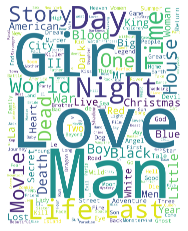

In [59]:
#Most popular words in the title of a movie
#Create title corpus
title_corpus = ' '.join(movies_metadata_df['title'])
from wordcloud import WordCloud, STOPWORDS
title_wordcloud = WordCloud(stopwords = STOPWORDS, background_color='white', height = 5000, width = 4000).generate(title_corpus)
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

Most popular word in title of the movie is - Love followed by Girl, Day and Man.

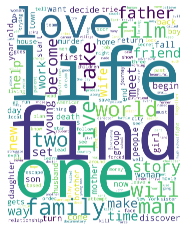

In [60]:
#Most common theme in overview of teh movie
overview_corpus = ' '.join(movies_metadata_df['overview'].dropna())
from wordcloud import WordCloud, STOPWORDS
overview_wordcloud = WordCloud(stopwords = STOPWORDS, background_color='white', height = 5000, width = 4000).generate(overview_corpus)
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

Most popular theme is - like followed by find, one.